In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [30]:
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Pennings/Validation_2024' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

C:\Users\arj26323\AppData\Local\Temp\ipykernel_8232\3621018739.py:9: FutureWarning: The provided callable <function sum at 0x000002ACC1D9FE20> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df_sum = df.groupby(['Plot','Latitude', 'Longitude', 'Year'], as_index = False).aggregate(
C:\Users\arj26323\AppData\Local\Temp\ipykernel_8232\3621018739.py:9: FutureWarning: The provided callable <function mean at 0x000002ACC1DDCDC0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_sum = df.groupby(['Plot','Latitude', 'Longitude', 'Year'], as_index = False).aggregate(


4036.388


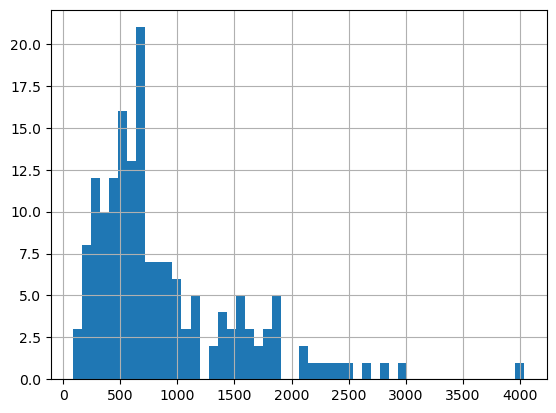

In [11]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

#df = df[df['Species_Code'] == 'A1'] ##Remove all non-Spartina alterniflora plots - messes up unique coordinates section
##Need to filter out other species later!

df = df[df['Zone'] >= 0] ##Zone "-1" in 2013 needs to be addressed - refers to old plot location that was relocated


df_sum = df.groupby(['Plot','Latitude', 'Longitude', 'Year'], as_index = False).aggregate(
    {
        'Plant_Biomass':[np.sum, np.size], 'Quadrat_Area':[np.mean], 
        'Species_Code':'first', 'Flowering_Status':'first','Date':'first'
    }
) 


df_sum.columns = [
    'Plot','Latitude','Longitude','Year','Plant_Biomass', 'Sample_Size', 'Quadrat_Area', 'Species_Code',
    'Flowering_Status', 'Date'
]


df_sum['Plant_Biomass'] = df_sum['Plant_Biomass']/df_sum['Quadrat_Area']

df_sum['Plant_Biomass'].hist(bins = 50)

df_sum
print(max(df_sum['Plant_Biomass']))


In [31]:
##Exporting coordinates

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, '2024_validation.csv')

#df_sum.to_csv(out_csv)

In [14]:
df_sum
df0 = df_sum[['Latitude', 'Longitude', 'Year', 'Plant_Biomass', 'Species_Code', 'Date']]
df0

Latitude  Longitude  Year  Plant_Biomass Species_Code       Date
0    31.335090 -81.478689  2024        770.690           A4 2024-10-14
1    31.335155 -81.478596  2024        815.772           A4 2024-10-14
2    31.351197 -81.333752  2024       1625.696           A1 2024-10-17
3    31.388340 -81.280132  2024        378.160           A1 2024-10-11
4    31.436011 -81.340698  2024        585.600           A1 2024-10-15
..         ...        ...   ...            ...          ...        ...
163  31.388004 -81.279872  2024        929.688           A1 2024-10-11
164  31.387745 -81.279730  2024        303.892           A1 2024-10-11
165  31.307682 -81.415608  2024       1571.188          A13 2024-10-14
166  31.538427 -81.422332  2024        198.556           A1 2024-10-12
167  31.535648 -81.295100  2024       2616.320           A1 2024-10-15

[168 rows x 6 columns]

In [15]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [19]:
fc_all = geemap.pandas_to_ee(df0, latitude = "Latitude", longitude = "Longitude")

In [20]:
Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)
# Map.addLayer(fc_all, {}, 'points')
# Map

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

In [21]:
def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [22]:
def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.2)
    return image.updateMask(mask1)

##ADDING NDVI (for min/max variables)
def addL5ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addL8ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

In [23]:
##Pixel extraction functions - addDate for dateless images/collections
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('imagedate').toInt())

##For Landsat images:
# def rasterExtraction(image):
#     feature = image.sampleRegions(
#         collection = fc_all,
#         scale = 30,
#         tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
#     )
#     return feature


def rasterExtraction(image, fc_subset):
    return image.sampleRegions(
        collection=fc_subset,  # Use the subset of locations
        scale=30,
        tileScale=8  # Adjust tile scale for performance
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))


##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

##FOR 1m DEM:
def dem1Extraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 1, 
        tileScale = 16 #ADDED 11/7/2022

    )
    return feature

In [24]:
ls8_collect = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)
ls9_collect = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)

#Merge
ultra_col = ls8_collect.merge(ls9_collect)

In [ ]:
##Adding DEM
dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.
dem1 = ee.ImageCollection('USGS/3DEP/1m')

##Set visualization parameters.
dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

Map.addLayer(dem, dem_params, '10m DEM')

In [25]:
#LANDSAT extraction

def rasterExtraction(image, fc_subset):
    return image.sampleRegions(
        collection=fc_subset,  # Use the subset of locations
        scale=30,
        tileScale=8  # Adjust tile scale for performance
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# Split locations into batches of 100
batch_size = 70
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2024, 2025)

for year in years:
    for batch in range(num_batches):
        # Subset locations for this batch
        fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

        print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

        # Filter Landsat images for the year
        subset = ultra_col.filterDate(f"{year}-01-01", f"{year}-12-31")

        # Fix: Use a lambda function to pass `fc_subset` properly
        extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

        fc_dict = extracted_features.getInfo()
        features = [feature['properties'] for feature in fc_dict['features']]
        df = pd.DataFrame(features)
        df['date'] = pd.to_datetime(df['date'])

        # Save file in the specified directory
        filename = os.path.join(out_dir, f"GALandsat_{year}_batch{batch + 1}.csv")
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

print("All batches processed!")

#2013 onward - need to reduce batch size from 200

Processing 2024, Batch 1/3...
Saved C:\Users\arj26323/Documents/All extract/2024_Validation\GALandsat_2024_batch1.csv
Processing 2024, Batch 2/3...
Saved C:\Users\arj26323/Documents/All extract/2024_Validation\GALandsat_2024_batch2.csv
Processing 2024, Batch 3/3...
Saved C:\Users\arj26323/Documents/All extract/2024_Validation\GALandsat_2024_batch3.csv
All batches processed!


In [28]:
##DAYMET
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_all).filterDate('2023', '2025')

# def dmExtraction(image, fc_subset):
#     return image.sampleRegions(
#         collection=fc_subset,
#         scale=1000,
#         tileScale=8  # Reducing from 16 to 8 to improve efficiency
#     ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

#Resampling daymet collection to 30m
def resamp_dm(img):
    resampled_dm = img.reproject(
        crs = 'EPSG:4326',
        scale = 30
    ).resample('bilinear')
    return resampled_dm
resamp_daymet = daymet.map(resamp_dm).map(addDate) #not sure if anything is actually changed

out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')



def xxx(image):
    return image.sampleRegions(
        collection=fc_all,
        scale=1000,
        tileScale=8  # Reducing from 16 to 8 to improve efficiency
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))


extracted_features = resamp_daymet.map(xxx)
fc_dict = extracted_features.getInfo()   
features = [feature['properties'] for feature in fc_dict['features']]
df = pd.DataFrame(features)
df


# Split locations into batches of 100
batch_size = 70
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2024, 2025)

for year in years:
    for batch in range(num_batches):
        # Subset locations for this batch
        fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

        print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

        # Filter Landsat images for the year
        subset = resamp_daymet.filterDate(f"{year}-01-01", f"{year}-12-31")

        # Fix: Use a lambda function to pass `fc_subset` properly
        extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

        fc_dict = extracted_features.getInfo()
        features = [feature['properties'] for feature in fc_dict['features']]
        df = pd.DataFrame(features)
        df['date'] = pd.to_datetime(df['date'])

        # Save file in the specified directory
        filename = os.path.join(out_dir, f"GADaymet_{year}_batch{batch + 1}.csv")
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

print("All batches processed!")

Processing 2024, Batch 1/3...


EEException: Collection query aborted after accumulating over 5000 elements.

In [ ]:
##GRIDMET
gridmet = ee.ImageCollection('GRIDMET/DROUGHT').filterBounds(fc_all)

resamp_gridmet = gridmet.map(resamp_dm).map(addDate)

out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# Split locations into batches of 100
batch_size = 100
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2024, 2025)

for year in years:
    for batch in range(num_batches):
        # Subset locations for this batch
        fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

        print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

        # Filter Landsat images for the year
        subset = resamp_gridmet.filterDate(f"{year}-01-01", f"{year}-12-31")

        # Fix: Use a lambda function to pass `fc_subset` properly
        extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

        fc_dict = extracted_features.getInfo()
        features = [feature['properties'] for feature in fc_dict['features']]
        df = pd.DataFrame(features)
        df['date'] = pd.to_datetime(df['date'])

        # Save file in the specified directory
        filename = os.path.join(out_dir, f"GAGridmet_{year}_batch{batch + 1}.csv")
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

print("All batches processed!")

In [ ]:
#Elevation

##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.

#Elevation
dem_extract = demExtraction(dem)
# dem_vals = geemap.ee_to_csv(dem_extract, 'dem.csv') ##10m dataset

dem_dict = dem_extract.getInfo()

# Extract the properties of the features into a list of dictionaries
features = [feature['properties'] for feature in dem_dict['features']]

# Convert the list of dictionaries into a pandas DataFrame
dem_vals = pd.DataFrame(features)
dem_vals

# out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# filename = os.path.join(out_dir, "elev.csv")

# dem_vals.to_csv(filename, index=False)

In [ ]:
##Slope
slope = ee.Terrain.slope(dem);

#Elevation
slope_extract = demExtraction(slope)

slope_dict = slope_extract.getInfo()

# Extract the properties of the features into a list of dictionaries
features = [feature['properties'] for feature in slope_dict['features']]

# Convert the list of dictionaries into a pandas DataFrame
slope_vals = pd.DataFrame(features)
slope_vals

# out_dir = os.path.expanduser('~/Documents/All extract/2024_Validation')

# filename = os.path.join(out_dir, "slope.csv")

# slope_vals.to_csv(filename, index=False)